In [2]:
using Distributions, Random, Plots, LinearAlgebra, LaTeXStrings, Statistics, StatsBase, Interpolations

In [3]:
# Implement Tauchen

function Tauchen(nzz, nz, rho, sigma, mu, q=3)
    
    """
       Implementation of the discretization method for an continuous process as proposed by Tauchen (1986).
       Takes the number number different states, sigma and rho (relevant estimates of the AR(1) process)
       as inputs. The last input, q, is the number of standard deviations associated with the grid range.
       Outputs are the grid (z_grid) and the transition matrix (pi).
    """
    
    pi = zeros(nz,nz) # storage
    uncond_sd = sqrt(sigma^2/(1-rho^2)) #calculate unconditional std. dev.
    z_grid = LinRange(-q*uncond_sd, q*uncond_sd, nz) # set up grid
    step_size = (q*uncond_sd+q*uncond_sd)/(nz-1) # step-size
    
    # Create instance for every possible transition
    for i in nzz
        for j in nzz
            # Border probabilities differ - we need to make two exceptions
            # First exception
            if j == 1
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma)
                
            # Second exception
            elseif j == maximum(nzz)
                pi[i,j] = 1 - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
                
            # Regular case
            else
                pi[i,j] = cdf(Normal(),(z_grid[j] + step_size/2 - rho*z_grid[i])/sigma) - cdf(Normal(),(z_grid[j] - step_size/2 - rho*z_grid[i])/sigma)
            end
        end
    end
    
    z_grid = mu/(1-rho) .+ z_grid
    
    return pi, z_grid
end

Tauchen (generic function with 2 methods)

In [4]:
tol = 0.001;
rho = 0.6
sigma = 1
mu = 1
nzz = 1:20
pi_matrix, d_grid = Tauchen(nzz, maximum(nzz), rho, sigma, 1)

([0.09635028564281957 0.08561663365701035 … 2.862083514632019e-8 3.2641064295901856e-9; 0.06184434878403554 0.06431474370104427 … 1.0334108535570152e-7 1.304840813176611e-8; … ; 1.3048408178167537e-8 1.033410853605403e-7 … 0.06431474370104429 0.06184434878403544; 3.264106404762731e-9 2.862083522122807e-8 … 0.08561663365701033 0.09635028564281956], range(-1.25, stop=6.25, length=20))

In [5]:
function value_fun_it(beta, d_grid = d_grid, pi=pi_matrix, tol=tol)
    
    # Do the value function iteration dance
    # Create containers
    v_exp = zeros(length(d_grid))
    V_store = zeros(length(d_grid))
    policy_index=zeros(length(d_grid))
    size_d=length(d_grid)
    
    dist = 1
    iter = 0
    
    # Start optimization
    while dist > tol

        for i in 1:size_d
                
            # Store all value functions for a given k and a given z - yields a vector with length 400
            v_temp = d_grid[i] .+ beta.*pi[i,:]'*v_exp
                
            # Find the maximum -> Optimal answer for a current state + capital combination
            V_store[i] = maximum(v_temp)
                
            # Save index as the policy index
            policy_index[i] = argmax(v_temp')[1]

        end
        
        # Update distance
        dist = norm(V_store - v_exp)/norm(v_exp) 
        iter = iter + 1

        println("$dist, $iter ")
        # Update guess
        v_exp = copy(V_store)

    end
    
    return V_store, policy_index, iter
end

value_fun_it (generic function with 4 methods)

In [6]:
beta = [0.3 0.6 0.9]
V_store = zeros(length(beta)+1, length(d_grid))
policy_function = zeros(length(beta)+1, length(d_grid))
iter = zeros(length(beta)+1)
q_true = zeros(length(beta)+1, length(d_grid))

for i in 1:length(beta)
    beta_n = beta[i]
    V_store[i,:], policy_function[i,:], iter[i] = value_fun_it(beta_n)
    q_true[i,:] = (beta_n / (1 - beta_n)) .* (1 / (1 - beta_n * rho)) .* (1 - rho) .* (1 / (1 - rho)) .+ 1 / (1 - beta_n * rho) .* d_grid
end

Inf, 1 
0.25238822812537504, 2 
0.05612695909789273, 3 
0.015502897260248876, 4 
0.004533847228132062, 5 
0.0013491026888755434, 6 
0.0004036530701904729, 7 
Inf, 1 
0.5047764562507501, 2 
0.1871923376534795, 3 
0.0923901703893507, 4 
0.05047950978592249, 5 
0.02884292862905532, 6 
0.016846423701210072, 7 
0.009954302155726132, 8 
0.005919698171335381, 9 
0.0035332792115624935, 10 
0.002113398370338422, 11 
0.0012656965004757914, 12 
0.00075857937862268, 13 
Inf, 1 
0.7571646843761248, 2 
0.3609231882863243, 3 
0.2336084726746492, 4 
0.17010129199871604, 5 
0.13136824383121687, 6 
0.10503799742258414, 7 
0.08594358175507764, 8 
0.07149779959676203, 9 
0.06023562102053265, 10 
0.0512543079177633, 11 
0.04396325835074692, 12 
0.03795851182179187, 13 
0.03295404007262151, 14 
0.028741562145625985, 15 
0.02516581996152386, 16 
0.022108744227418802, 17 
0.019478976912822372, 18 
0.017204745320249685, 19 
0.015228900021850799, 20 
0.013505387589426385, 21 
0.011996696962677982, 22 
0.0106719

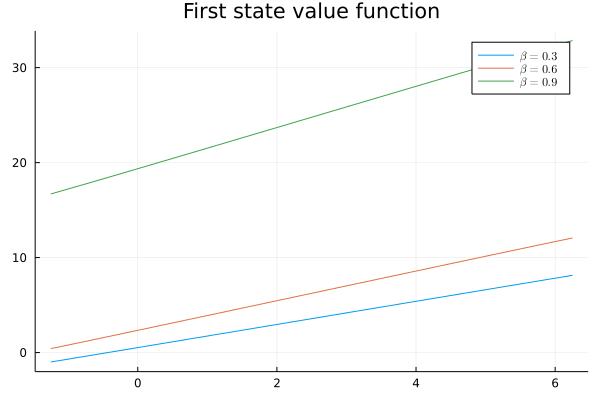

In [7]:
plot(d_grid, [V_store[1,:],V_store[2,:], V_store[3,:]], label=[L"\beta = 0.3" L"\beta = 0.6" L"\beta=0.9"], title="First state value function")

In [8]:
# Number of Simulations
S = 5
# Number of Periods
T = 100
beta_true = 0.8
Random.seed!(3333)

function sim_data_d(S, T, sigma=sigma, mu=mu, rho=rho)
    
    errors = zeros(S,T)

    d_empiric = zeros(S,T+1)

    for sim in 1:S

        dist = Normal(0, sigma)
        errors[sim,:] = rand(dist, T)

        for t in 1:T
            d_empiric[sim,t+1] = mu .+ rho*d_empiric[sim,t] + errors[sim,t] # should be t+1 but since iid doesn't matter
        end
    end
    
    return d_empiric
end
    
d_empiric = sim_data_d(5, 100)
q_empiric = (beta_true / (1 - beta_true)) .* (1 / (1 - beta_true * rho)) .* (1 - rho) .* (1 / (1 - rho)) .+ 1 / (1 - beta_true * rho) .* d_empiric

5×101 Matrix{Float64}:
 7.69231  10.7309   14.8053   …  10.2466  13.1058  14.901   17.4177
 7.69231   9.23399   8.25625     13.2318  11.0259  15.5703  13.8109
 7.69231  11.3458   13.4027      12.0141  11.075   12.2835  12.3658
 7.69231   8.57698   7.36061     10.5322  11.262   11.3662   5.16172
 7.69231   9.67279   8.33679     14.2956  11.8558  13.6959  13.7764

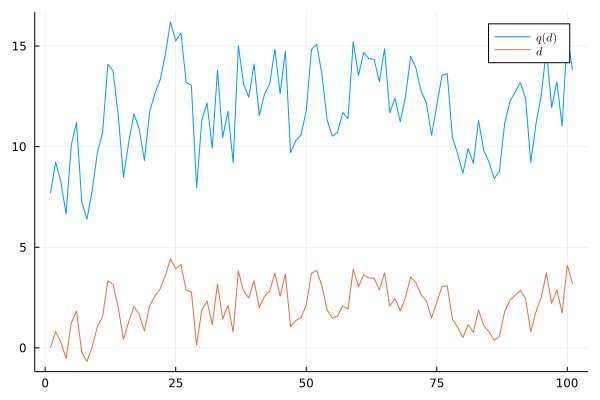

In [9]:
plot([q_empiric[2,:] d_empiric[2,:]], label=[L"q(d)" L"d"])

In [10]:
# Create chain of states (markov-chain)

function mc_states(S, T, nzz, grid, pi_mat)

    states = zeros(S, T+2)
    states_idx = ones(S, T+1) # Start in first of the 20 states

    for sim in 1:S

        for t in 2:T+1

            states_idx[sim, t] = sample(nzz, Weights(pi_mat[Int.(states_idx[sim,t-1]),:]))
            states[sim, t+1] = d_grid[Int.(states_idx[sim,t])]
        end

    end

    states = states[:,3:end]
    states_idx = states_idx[:,2:end];
    
    return states, states_idx
end

mc_states (generic function with 1 method)

In [11]:
function criterion(sim_moments, data_moments, W)
    
    criterion = ((sim_moments - data_moments) * W * (sim_moments - data_moments)')[1]

    return criterion
    
end

criterion (generic function with 1 method)

In [12]:
states, states_idx = mc_states(5, 100, nzz, d_grid, pi_matrix)

([-0.855263157894737 0.32894736842105243 … 1.5131578947368418 2.302631578947368; 0.7236842105263156 1.1184210526315788 … 2.302631578947368 2.302631578947368; … ; -0.4605263157894738 1.9078947368421049 … 0.7236842105263156 1.1184210526315788; -0.4605263157894738 -0.06578947368421051 … 3.092105263157895 0.32894736842105243], [2.0 5.0 … 8.0 10.0; 6.0 7.0 … 10.0 10.0; … ; 3.0 9.0 … 6.0 7.0; 3.0 4.0 … 12.0 5.0])

In [13]:
beta = LinRange(0.1,1,100)
q_sim = zeros(length(beta), S, T)
V_store_sim = zeros(length(beta), length(d_grid))
policy_function_sim = zeros(length(beta), length(d_grid))
iter_sim = zeros(length(beta))

means = zeros(length(beta), S)
vars = zeros(length(beta), S)
mean_sim = zeros(length(beta))
var_sim = zeros(length(beta))
dist_beta = zeros(length(beta))

for i in 1:length(beta)
    beta_n = beta[i]
    
    V_store_sim[i,:], policy_function_sim[i,:], iter_sim[i] = value_fun_it(beta_n)
    
    for sim in 1:S
        
        for idx in 1:T
            q_sim[i,sim,idx] = V_store_sim[Int.(i), Int.(states_idx[sim,idx])]
        end
        
        means[i,sim] = mean(q_sim[i,sim,:])
        vars[i,sim] = var(q_sim[i,sim,:])
    end
    
    mean_sim[i] = mean(means[i,:])
    var_sim[i] = mean(vars[i,:])
    
    dist_beta[i] = criterion([mean(means[i,:]) mean(vars[i,:])], [mean(q_empiric) var(q_empiric)], Matrix(1.0I, 2, 2))
end

Inf, 1 
0.08412940937512499, 2 
0.007185456915092799, 3 
0.0006916656136522708, 4 
Inf, 1 
0.09177753750013636, 2 
0.008492723489843191, 3 
0.000890751656055133, 4 
Inf, 1 
0.09942566562514772, 2 
0.009899334878835852, 3 
0.0011233563878295836, 4 
0.00013107619366800635, 5 
Inf, 1 
0.10707379375015912, 2 
0.011403267528159153, 3 
0.001391639288701419, 4 
0.00017483003393070938, 5 
Inf, 1 
0.1147219218751705, 2 
0.013002551156368069, 3 
0.0016976670692256004, 4 
0.00022844889652956035, 5 
Inf, 1 
0.12237005000018182, 2 
0.014695267057102985, 3 
0.0020434150762690564, 4 
0.00029321795884510327, 5 
Inf, 1 
0.13001817812519323, 2 
0.016479546464397345, 3 
0.002430768773624139, 4 
0.0003704753070662147, 5 
Inf, 1 
0.1376663062502045, 2 
0.01835356897807638, 3 
0.0028615252909754323, 4 
0.0004616074089051826, 5 
Inf, 1 
0.1453144343752159, 2 
0.02031556104676423, 3 
0.0033373950346414884, 4 
0.0005680446271946736, 5 
Inf, 1 
0.1529625625002273, 2 
0.022363794506132628, 3 
0.00386000335372140

In [14]:
idx_min = argmin(dist_beta)

78

In [15]:
beta[idx_min]

0.8

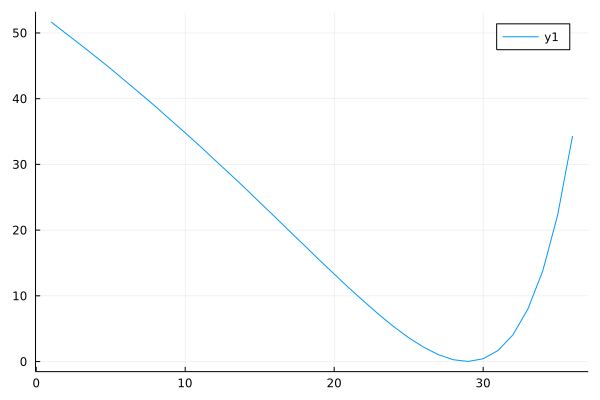

In [16]:
plot(dist_beta[50:85])

In [17]:
# Create Weighting Matrix

# Extract optimal sequence
q_boot = zeros(100)
for obs in 1:length(q_sim[39,1,:])
    q_boot[obs] = mean(q_sim[39,:,obs]) # First simulation or average? Here, average.
end

n_boot = 500
bootstrap_store = zeros(500, length(q_boot))
moments_store = zeros(500, 2) # as we collect two moments - mean and variance

for boot in 1:n_boot
    bootstrap_store[boot,:] = sample(q_boot, length(q_boot))
    moments_store[boot, 1:2] = [mean(bootstrap_store[boot,:]) var(bootstrap_store[boot,:])]
end

vcv = copy(cov(moments_store))
W = copy(inv(vcv)) #upper left element variance of mean; lower left element variance of variance

2×2 Matrix{Float64}:
 171.227   31.8976
  31.8976  52.0757

In [18]:
# Do the same with bootstrapped, simulated data
beta_boot = LinRange(0.1,1, 100)
q_sim_boot = zeros(length(beta), S, T)
V_store_sim_boot = zeros(length(beta), length(d_grid))
policy_function_sim_boot = zeros(length(beta), length(d_grid))
iter_sim_boot = zeros(length(beta))

means_boot = zeros(length(beta), S)
vars_boot = zeros(length(beta), S)
mean_sim_boot = zeros(length(beta))
var_sim_boot = zeros(length(beta))
dist_beta_boot = zeros(length(beta))

for i in 1:length(beta)
    beta_n = beta[i]
    
    V_store_sim_boot[i,:], policy_function_sim_boot[i,:], iter_sim_boot[i] = value_fun_it(beta_n)
    
    for sim in 1:S
        
        for idx in 1:T
            q_sim_boot[i,sim,idx] = V_store_sim_boot[Int.(i), Int.(states_idx[sim,idx])]
        end
        
        means_boot[i,sim] = mean(q_sim_boot[i,sim,:])
        vars_boot[i,sim] = var(q_sim_boot[i,sim,:])
    end
    
    mean_sim_boot[i] = mean(means_boot[i,:])
    var_sim_boot[i] = mean(vars_boot[i,:])
    
    dist_beta_boot[i] = (([mean(means_boot[i,:]) mean(vars_boot[i,:])] - [mean(q_empiric) var(q_empiric)]) * W * ([mean(means_boot[i,:]) mean(vars_boot[i,:])] - [mean(q_empiric) var(q_empiric)])')[1]

end

Inf, 1 
0.08412940937512499, 2 
0.007185456915092799, 3 
0.0006916656136522708, 4 
Inf, 1 
0.09177753750013636, 2 
0.008492723489843191, 3 
0.000890751656055133, 4 
Inf, 1 
0.09942566562514772, 2 
0.009899334878835852, 3 
0.0011233563878295836, 4 
0.00013107619366800635, 5 
Inf, 1 
0.10707379375015912, 2 
0.011403267528159153, 3 
0.001391639288701419, 4 
0.00017483003393070938, 5 
Inf, 1 
0.1147219218751705, 2 
0.013002551156368069, 3 
0.0016976670692256004, 4 
0.00022844889652956035, 5 
Inf, 1 
0.12237005000018182, 2 
0.014695267057102985, 3 
0.0020434150762690564, 4 
0.00029321795884510327, 5 
Inf, 1 
0.13001817812519323, 2 
0.016479546464397345, 3 
0.002430768773624139, 4 
0.0003704753070662147, 5 
Inf, 1 
0.1376663062502045, 2 
0.01835356897807638, 3 
0.0028615252909754323, 4 
0.0004616074089051826, 5 
Inf, 1 
0.1453144343752159, 2 
0.02031556104676423, 3 
0.0033373950346414884, 4 
0.0005680446271946736, 5 
Inf, 1 
0.1529625625002273, 2 
0.022363794506132628, 3 
0.00386000335372140

In [19]:
idx_min_boot = argmin(dist_beta_boot)

78

In [20]:
beta_boot[idx_min_boot]

0.8

In [21]:
W

2×2 Matrix{Float64}:
 171.227   31.8976
  31.8976  52.0757

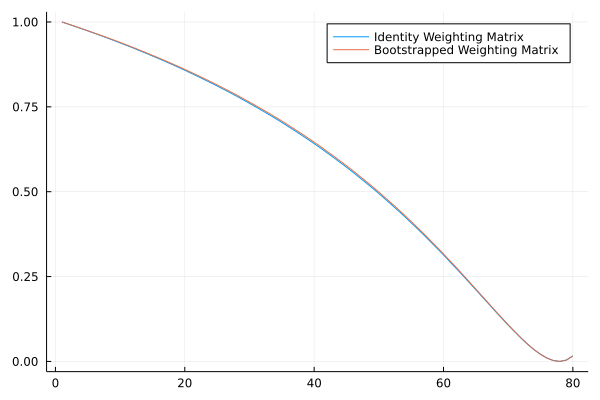

In [25]:
plot([dist_beta[1:80]/dist_beta[1] dist_beta_boot[1:80]/dist_beta_boot[1]], 
    label=["Identity Weighting Matrix" "Bootstrapped Weighting Matrix"]) # small impact of updated weighting matrix

In [23]:
# next step: Put everything in another loop 1:nss where we simulate new d data, new shock